In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib qt
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))
import seaborn as sns
sns.set_theme(style="darkgrid")


In [3]:
import sys
# sys.path.append('../')
sys.path.append('../')
sys.path.append('../model')
sys.path.append('../cost')
sys.path.append('../constraints')
sys.path.append('../sensor')
import QuadRotorSmallAngleModel
import QuadRotorSmallAngleCost
import QuadRotorSmallAngleConstraints
import QuadRotorSensor
from scipy.integrate import solve_ivp
from Scvx import Scvx

In [4]:
ix = 12
iu = 4
ih = 4
tf = 5
N = 50
delT = tf/N

In [5]:
# obstacle
r_safe = 0.3

c1 = np.array([1,4,0])
r1 = 0.3
H1_obs = np.diag([1/r1,1/r1,0])
H1_safe = np.diag([1/(r1+r_safe),1/(r1+r_safe),0])

c2 = np.array([1,2,0])
r2 = 0.5
H2_obs = np.diag([1/r2,1/r2,0])
H2_safe = np.diag([1/(r2+r_safe),1/(r2+r_safe),0])

c3 = np.array([-1,4,0])
r3 = 0.4
H3_obs = np.diag([1/r3,1/r3,0])
H3_safe = np.diag([1/(r3+r_safe),1/(r3+r_safe),0])

c4 = np.array([-1,2,0])
r4 = 0.3
H4_obs = np.diag([1/r4,1/r4,0])
H4_safe = np.diag([1/(r4+r_safe),1/(r4+r_safe),0])


c = []
c.append(c1)
c.append(c2)
c.append(c3)
c.append(c4)
H_obs = []
H_obs.append(H1_obs)
H_obs.append(H2_obs)
H_obs.append(H3_obs)
H_obs.append(H4_obs)
H_safe = []
H_safe.append(H1_safe)
H_safe.append(H2_safe)
H_safe.append(H3_safe)
H_safe.append(H4_safe)
r = []
r.append(r1)
r.append(r2)
r.append(r3)
r.append(r4)


assert len(c) == len(H_obs)
assert len(c) == len(H_safe)
num_obstacle = len(c)

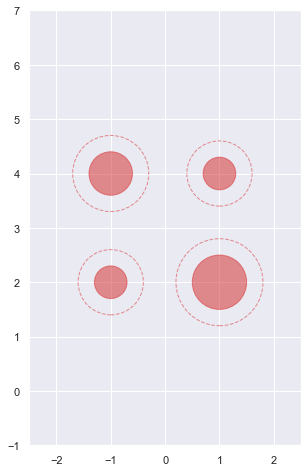

In [6]:
plt.figure(figsize=(5,8))
ax=plt.gca()
for ce,re in zip(c,r) :
    circle1 = plt.Circle((ce[0],ce[1]),re,color='tab:red',alpha=0.5,fill=True)
    circle2 = plt.Circle((ce[0],ce[1]),re+r_safe,linestyle='--',color='tab:red',alpha=0.5,fill=False)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
plt.axis([-2.5, 2.5, -1, 7])
plt.gca().set_aspect('equal', adjustable='box')

In [7]:
xi = np.array([2,6,0,0,0,0,0,0,0,0,0,0])
xf = np.array([0,0,0,0,0,0,0,0,0,0,0,0])

myModel = QuadRotorSmallAngleModel.quadrotorsa('Hello',ix,iu,delT,linearization="numeric_central")
myCost = QuadRotorSmallAngleCost.quadrotorsa('Hello',ix,iu,N)
myConst = QuadRotorSmallAngleConstraints.quadrotorsa('Hello',ix,iu,ih,c,H_safe)
myObs = QuadRotorSensor.lidar('Hello',ix,iu)

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf

u0 = np.zeros((N+1,iu))
u0[:,0] = 9.81

In [10]:
max_iter = 30
# i1 = Scvx('notebook',N,max_iter,myModel,myCost,myConst,
# type_discretization='zoh',w_c=1,w_vc=1e4,w_tr=1e2,tol_vc=1e-8) # 2504.53
i1 = Scvx('notebook',N,max_iter,myModel,myCost,myConst,
type_discretization='zoh',w_c=1e-3,w_vc=1e4,w_tr=1e-3,tol_vc=1e-10) # 2504.53
x,u,xbar,ubar,total_num_iter = i1.update(x0,u0,xi,xf)

iteration   total_cost  cost        ||vc||     ||tr||       reduction   expected    w_tr        bounary
1           2.5468945   2.5060523   4.32e-13    40.8        -52.1       2.45e+03    0.001       0(2.29)
2           2.4979821   2.4923833   2.31e-13    5.6         -2.49e+03   0.0489      0.001       0(1.17)
3           2.4900788   2.4765872   2.44e-13    13.5        -2.47e+03   0.0079      0.001       0(2.29)
non-positive expected reduction
4           2.5197844   2.5097628   4.94e-14    10          -2.51e+03   -0.0297     0.001       0(0.54)
5           2.5190022   2.518672    2.23e-13    0.33        -2.52e+03   0.000782    0.001       0(0.0292)
non-positive expected reduction
6           2.5191003   2.5190185   2.08e-13    0.0818      -2.52e+03   -9.81e-05   0.001       1(0.000974)
7           2.5189684   2.5189184   2.26e-13    0.0501      -2.52e+03   0.000132    0.001       1(0.00028)
8           2.5188946   2.5188673   2.53e-13    0.0273      -2.52e+03   7.38e-05    0.001      

In [11]:
list_time = delT * np.array([i for i in range(N+1)])

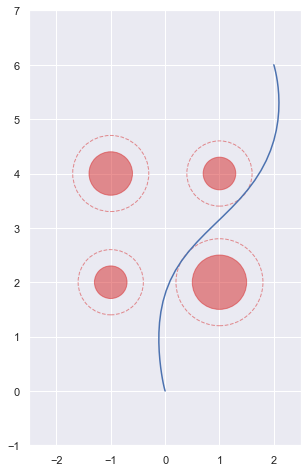

In [12]:
%matplotlib inline
plt.figure(figsize=(5,8))
ax=plt.gca()
for ce,re in zip(c,r) :
    circle1 = plt.Circle((ce[0],ce[1]),re,color='tab:red',alpha=0.5,fill=True)
    circle2 = plt.Circle((ce[0],ce[1]),re+r_safe,linestyle='--',color='tab:red',alpha=0.5,fill=False)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
plt.plot(xbar[:,0],xbar[:,1])
plt.axis([-2.5, 2.5, -1, 7])
plt.gca().set_aspect('equal', adjustable='box')

Text(0, 0.5, 'yaw dot')

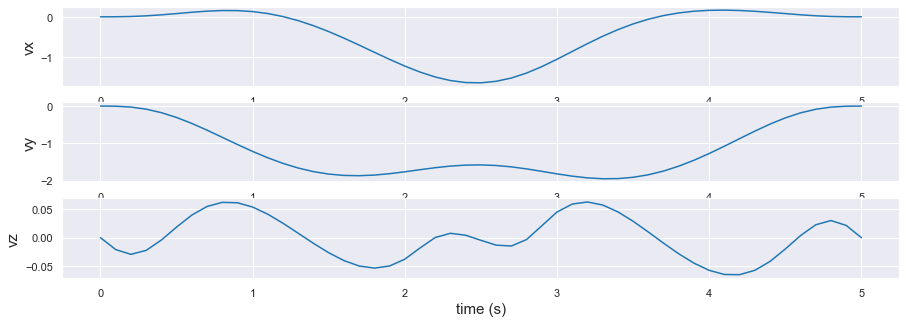

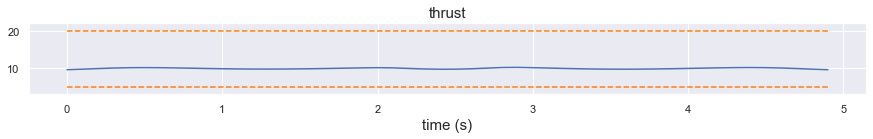

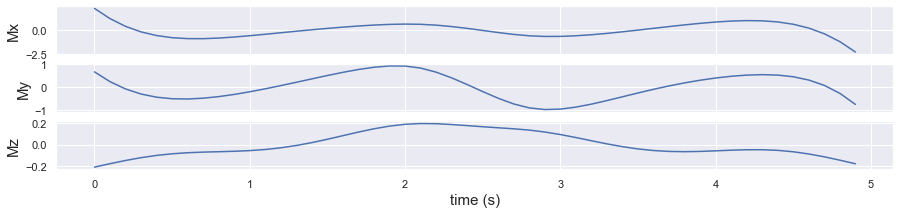

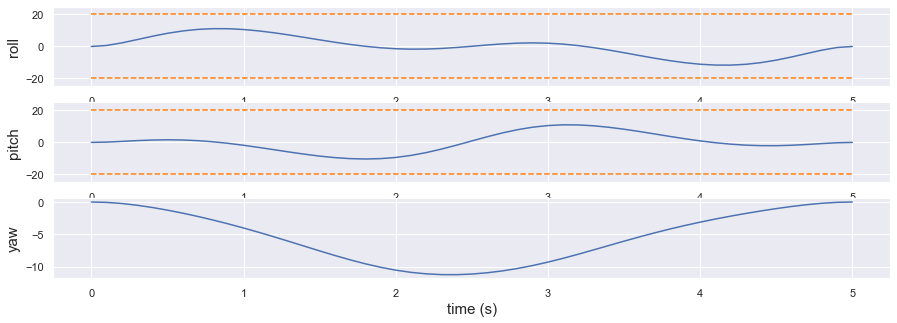

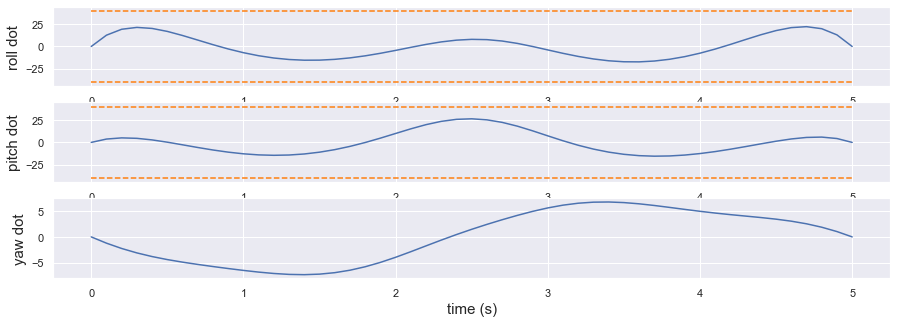

In [13]:
%matplotlib inline
fS = 15
plt.figure(0,figsize=(15,5))
plt.subplot(311)
plt.plot(list_time,x[:,6],color='tab:blue')
# plt.plot(list_time,list_time*0+np.rad2deg(myConst.roll_max),'--',color='tab:orange')
# plt.plot(list_time,list_time*0-np.rad2deg(myConst.roll_max),'--',color='tab:orange')
# plt.ylim([-5-np.rad2deg(myConst.roll_max),5+np.rad2deg(myConst.roll_max)])
plt.xlabel('time (s)',fontsize=fS)
plt.ylabel('vx',fontsize=fS)
plt.subplot(312)
plt.plot(list_time,x[:,7],color='tab:blue')
# plt.plot(list_time,list_time*0+np.rad2deg(myConst.pitch_max),'--',color='tab:orange')
# plt.plot(list_time,list_time*0-np.rad2deg(myConst.pitch_max),'--',color='tab:orange')
# plt.ylim([-5-np.rad2deg(myConst.pitch_max),5+np.rad2deg(myConst.pitch_max)])
plt.xlabel('time (s)',fontsize=fS)
plt.ylabel('vy',fontsize=fS)
plt.subplot(313)
plt.plot(list_time,x[:,8],color='tab:blue')
plt.xlabel('time (s)',fontsize=fS)
plt.ylabel('vz',fontsize=fS)

plt.figure(1,figsize=(15,6))
plt.subplot(411)
plt.plot(list_time[:N],u[:N,0])
plt.plot(list_time[:N],list_time[:N]*0+myConst.T_max,'--',color='tab:orange')
plt.plot(list_time[:N],list_time[:N]*0+myConst.T_min,'--',color='tab:orange')
plt.xlabel('time (s)',fontsize=fS)
plt.ylim([-2+myConst.T_min,2+myConst.T_max])
plt.title('thrust',fontsize=fS)

plt.figure(2,figsize=(15,3))
plt.subplot(311)
plt.plot(list_time[:N],u[:N,1])
plt.xlabel('time (s)',fontsize=fS)
plt.ylabel('Mx',fontsize=fS)
plt.subplot(312)
plt.plot(list_time[:N],u[:N,2])
plt.xlabel('time (s)',fontsize=fS)
plt.ylabel('My',fontsize=fS)
plt.subplot(313)
plt.plot(list_time[:N],u[:N,3])
plt.xlabel('time (s)',fontsize=fS)
plt.ylabel('Mz',fontsize=fS)

plt.figure(3,figsize=(15,5))
plt.subplot(311)
plt.plot(list_time,np.rad2deg(x[:,3]))
plt.plot(list_time,list_time*0+np.rad2deg(myConst.roll_max),'--',color='tab:orange')
plt.plot(list_time,list_time*0-np.rad2deg(myConst.roll_max),'--',color='tab:orange')
plt.ylim([-5-np.rad2deg(myConst.roll_max),5+np.rad2deg(myConst.roll_max)])
plt.xlabel('time (s)',fontsize=fS)
plt.ylabel('roll',fontsize=fS)
plt.subplot(312)
plt.plot(list_time,np.rad2deg(x[:,4]))
plt.plot(list_time,list_time*0+np.rad2deg(myConst.pitch_max),'--',color='tab:orange')
plt.plot(list_time,list_time*0-np.rad2deg(myConst.pitch_max),'--',color='tab:orange')
plt.ylim([-5-np.rad2deg(myConst.pitch_max),5+np.rad2deg(myConst.pitch_max)])
plt.xlabel('time (s)',fontsize=fS)
plt.ylabel('pitch',fontsize=fS)
plt.subplot(313)
plt.plot(list_time,np.rad2deg(x[:,5]))
plt.xlabel('time (s)',fontsize=fS)
plt.ylabel('yaw',fontsize=fS)

plt.figure(4,figsize=(15,5))
plt.subplot(311)
plt.plot(list_time,np.rad2deg(x[:,9]))
plt.plot(list_time,list_time*0+np.rad2deg(myConst.rolldot_max),'--',color='tab:orange')
plt.plot(list_time,list_time*0-np.rad2deg(myConst.rolldot_max),'--',color='tab:orange')
plt.ylim([-5-np.rad2deg(myConst.rolldot_max),5+np.rad2deg(myConst.rolldot_max)])
plt.xlabel('time (s)',fontsize=fS)
plt.ylabel('roll dot',fontsize=fS)
plt.subplot(312)
plt.plot(list_time,np.rad2deg(x[:,10]))
plt.plot(list_time,list_time*0+np.rad2deg(myConst.pitchdot_max),'--',color='tab:orange')
plt.plot(list_time,list_time*0-np.rad2deg(myConst.pitchdot_max),'--',color='tab:orange')
plt.ylim([-5-np.rad2deg(myConst.pitchdot_max),5+np.rad2deg(myConst.pitchdot_max)])
plt.xlabel('time (s)',fontsize=fS)
plt.ylabel('pitch dot',fontsize=fS)
plt.subplot(313)
plt.plot(list_time,np.rad2deg(x[:,11]))
plt.xlabel('time (s)',fontsize=fS)
plt.ylabel('yaw dot',fontsize=fS)


In [14]:
obs = myObs.state2obs(x,c,H_obs)

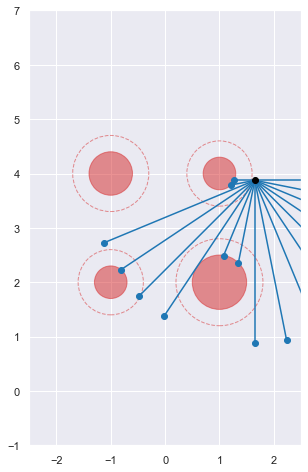

In [15]:
idx = 20
xp = x[idx]
lp = obs['point'][idx]
plt.figure(figsize=(5,8))
ax=plt.gca()
for ce,re in zip(c,r) :
    circle1 = plt.Circle((ce[0],ce[1]),re,color='tab:red',alpha=0.5,fill=True)
    circle2 = plt.Circle((ce[0],ce[1]),re+r_safe,linestyle='--',color='tab:red',alpha=0.5,fill=False)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
for ro in lp :
    plt.plot([xp[0],ro[0]],[xp[1],ro[1]],color='tab:blue')
    plt.plot(ro[0],ro[1],'o',color='tab:blue')
plt.plot(xp[0],xp[1],'o',color='black')
plt.axis([-2.5, 2.5, -1, 7])
plt.gca().set_aspect('equal', adjustable='box')

In [ ]:
import imageio
from utils import make_quadrotor_trajectory_fig
make_quadrotor_trajectory_fig(x,obs,c,H,r)